Mid-level
Pasinaudodami Vyriausiosios rinkimų komisijos valdomu API gaukite 2023 m. savivaldybių tarybų ir
merų rinkimų II turo duomenis, kuriais naudodamiesi:
1. raskite kandidatus, kurių gauto palaikymo dalis, skirta balsais paštu, buvo statistiškai
reikšmingai didesnė, lyginant su jų konkurentais toje pačioje rinkimų apygardoje tame
pačiame rinkimų ture;

In [9]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Load the data from CSV file
df = pd.read_csv("VN_1304_2_1920.csv", delimiter="\t")

df.info()

#we need column BALSU_PASTU and BALSU_VISO for analysis, they both don't have null values and int type
#so it's good for analysis, and each district has 2 candidates as it's 2nd round of election

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   APYGARDOS_NR                 2362 non-null   int64  
 1   APYGARDOS_PAVADINIMAS        2362 non-null   object 
 2   APYLINKES_NR                 2362 non-null   int64  
 3   APYLINKES_PAVADINIMAS        2362 non-null   object 
 4   RINKEJU_SKAICIUS             2362 non-null   int64  
 5   VISO_DALYVAVO                2362 non-null   int64  
 6   BALSADEZEJE_GALIOJANTYS      2362 non-null   int64  
 7   BALSADEZEJE_NEGALIOJANTYS    2362 non-null   int64  
 8   PASTU_GALIOJANTYS            2362 non-null   int64  
 9   PASTU_NEGALIOJANTYS          2362 non-null   int64  
 10  VARDAS                       2362 non-null   object 
 11  PAVARDE                      2362 non-null   object 
 12  PARTIJA                      2333 non-null   object 
 13  BALSU_BALSADEZEJE 

In [18]:
df.head()

,APYGARDOS_NR,APYGARDOS_PAVADINIMAS,APYLINKES_NR,APYLINKES_PAVADINIMAS,RINKEJU_SKAICIUS,VISO_DALYVAVO,BALSADEZEJE_GALIOJANTYS,BALSADEZEJE_NEGALIOJANTYS,PASTU_GALIOJANTYS,PASTU_NEGALIOJANTYS,...,PAVARDE,PARTIJA,BALSU_BALSADEZEJE,BALSU_PASTU,BALSU_VISO,PAPILDOMO_PROTOKOLO_POZYMIS,RKND_V_AR_ISSIKELE_PATS,RPL_UNIKALUS_NUMERIS,SAV,Sugeneravimo data
0,3,Alytaus rajono,2,Mikutiškių,770,417,328,2,85,2,...,VITKAUSKIENĖ,Demokratų sąjunga „Vardan Lietuvos“,185,29,214,NaN,NaN,3002,Alytaus rajono savivaldybė,2023-03-24 16:17
1,3,Alytaus rajono,2,Mikutiškių,770,417,328,2,85,2,...,VRUBLIAUSKAS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,143,56,199,NaN,NaN,3002,Alytaus rajono savivaldybė,2023-03-24 16:17
2,3,Alytaus rajono,3,Genių,393,215,177,1,36,1,...,VRUBLIAUSKAS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,95,16,111,NaN,NaN,3003,Alytaus rajono savivaldybė,2023-03-24 16:17
3,3,Alytaus rajono,3,Genių,393,215,177,1,36,1,...,VITKAUSKIENĖ,Demokratų sąjunga „Vardan Lietuvos“,82,20,102,NaN,NaN,3003,Alytaus rajono savivaldybė,2023-03-24 16:17
4,3,Alytaus rajono,4,Miklusėnų,1319,774,671,8,95,0,...,VITKAUSKIENĖ,Demokratų sąjunga „Vardan Lietuvos“,363,45,408,NaN,NaN,3004,Alytaus rajono savivaldybė,2023-03-24 16:17


In [10]:
#we create a list for significant_candidates for votes per mail
significant_candidates = []

# Group by district
for district, group in df.groupby("APYGARDOS_PAVADINIMAS"):
    # Group by surname and party in each district and sum the votes
    candidates = group.groupby(["PAVARDE", "PARTIJA"]).agg({
        "BALSU_PASTU": "sum",
        "BALSU_VISO": "sum"
    }).reset_index()

    # Only continue if exactly 2 candidates
    if len(candidates) != 2:
        continue

    # Get the two candidates
    c1, c2 = candidates.iloc[0], candidates.iloc[1]

    # Test both directions: is c1 > c2 or c2 > c1?
# Perform a proportion z-test Is candidate's mail to total votes percent significantly higher than opponent's?
    for candidate, opponent in [(c1, c2), (c2, c1)]:
        stat, pval = proportions_ztest(
            [candidate["BALSU_PASTU"], opponent["BALSU_PASTU"]],
            [candidate["BALSU_VISO"], opponent["BALSU_VISO"]],
            alternative='larger'
        )
        # If p-value is small (less than 0.05), we are confident the difference is real
        if pval < 0.05:
            # Save candidate info to the results list
            significant_candidates.append({
                "PAVARDE": candidate["PAVARDE"],
                "PARTIJA": candidate["PARTIJA"],
                "APYGARDOS_PAVADINIMAS": district,
                "MAIL_PROPORTION": candidate["BALSU_PASTU"] / candidate["BALSU_VISO"],
                "P_VALUE": pval
            })
            break  # only record one winner per district

# Convert to DataFrame and show results
result_df = pd.DataFrame(significant_candidates)
result_df.head()


,PAVARDE,PARTIJA,APYGARDOS_PAVADINIMAS,MAIL_PROPORTION,P_VALUE
0,VRUBLIAUSKAS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,Alytaus rajono,0.300968,1.847743e-49
1,ŽIOGELIS,Lietuvos socialdemokratų partija,Anykščių rajono,0.315731,1.387370e-06
2,KNIZIKEVIČIUS,Lietuvos socialdemokratų partija,Biržų rajono,0.339975,1.269485e-12
3,TOMKUS,Tėvynės sąjunga-Lietuvos krikščionys demokratai,Kaišiadorių rajono,0.300000,1.675380e-04
4,BABECKAS,Demokratų sąjunga „Vardan Lietuvos“,Kalvarijos,0.334096,1.552150e-03


2. žemėlapyje pavaizduokite rinkimų apylinkes ir partijas, kurių kandidatų tose apylinkėse gauto
palaikymo dalis, skirta balsais paštu, buvo statistiškai reikšmingai didesnė, lyginant su jų
konkurentais toje pačioje rinkimų apylinkėje tame pačiame rinkimų ture.

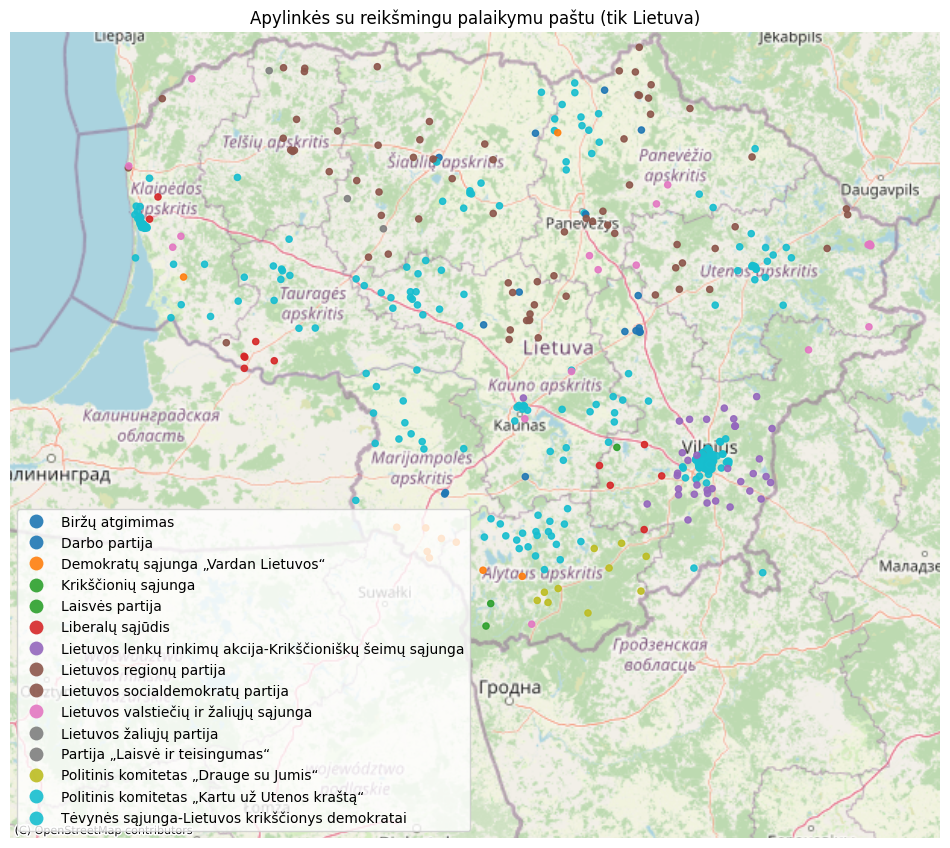

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Load coordinates from Excel
coords_df = pd.read_excel("Rinkimu_apylinkes_2024-08-29.xlsx")

# 2. Clean and rename columns
# coords_df.columns = coords_df.columns.str.strip().str.lower()
coords_df = coords_df.rename(columns={
    # "Apylinkės pavadinimas": "APYLINKES_PAVADINIMAS",
    "Balsavimo X koordinatė": "X",
    "Balsavimo Y koordinatė": "Y"
})
coords_df["APYLINKES_PAVADINIMAS"] = coords_df["Apylinkės pavadinimas"].str.strip().str.upper()

# Convert to GeoDataFrame (LKS94 EPSG:3346 → to match Excel)
gdf = gpd.GeoDataFrame(
    coords_df,
    geometry=gpd.points_from_xy(coords_df["X"], coords_df["Y"]),
    crs="EPSG:3346"
)

# Reproject to WGS84 for merging with result DataFrame
gdf_latlon = gdf.to_crs(epsg=4326)

# 5. Load significant result DataFrame (from previous z-test analysis)

# Perform analysis
significant = []

for name, group in df.groupby("APYLINKES_PAVADINIMAS"):
    candidates = group.groupby(["PAVARDE", "PARTIJA"]).agg({
        "BALSU_PASTU": "sum",
        "BALSU_VISO": "sum"
    }).reset_index()

    if len(candidates) != 2:
        continue

    c1, c2 = candidates.iloc[0], candidates.iloc[1]

    # test if c1 > c2
    stat, pval = proportions_ztest(
        [c1["BALSU_PASTU"], c2["BALSU_PASTU"]],
        [c1["BALSU_VISO"], c2["BALSU_VISO"]],
        alternative='larger'
    )

    if pval < 0.05:
        significant.append({
            "APYLINKES_PAVADINIMAS": name,
            "PARTIJA": c1["PARTIJA"]
        })
    else:
        # test if c2 > c1
        stat, pval = proportions_ztest(
            [c2["BALSU_PASTU"], c1["BALSU_PASTU"]],
            [c2["BALSU_VISO"], c1["BALSU_VISO"]],
            alternative='larger'
        )
        if pval < 0.05:
            significant.append({
                "APYLINKES_PAVADINIMAS": name,
                "PARTIJA": c2["PARTIJA"]
            })

# Create DataFrame of significant apylinkės
df_sig = pd.DataFrame(significant)

# Make sure apylinkės names match format
df_sig["APYLINKES_PAVADINIMAS"] = df_sig["APYLINKES_PAVADINIMAS"].str.strip().str.upper()

gdf_latlon = gdf_latlon.merge(df_sig[["APYLINKES_PAVADINIMAS", "PARTIJA"]], on="APYLINKES_PAVADINIMAS", how="left")
# gdf_latlon["PARTIJA"] = gdf_latlon["PARTIJA"].fillna("Kita")

# Reproject to Web Mercator (EPSG:3857) for basemap
gdf_3857 = gdf_latlon.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

gdf_3857.plot(
    ax=ax,
    column="PARTIJA",
    legend=True,
    markersize=20,
    alpha=0.9,
    categorical=True
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set map extent to Lithuania
ax.set_xlim(2250000, 3000000)
ax.set_ylim(7000000, 7650000)

# Add base map and finalize plot
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Apylinkės su reikšmingu palaikymu paštu (tik Lietuva)")
plt.show()
